In [1]:
from src.utils import *

# Wczytywanie i wstępne przetwarzanie sygnału EEG

In [2]:
name = "mati_wyobrazenie"
xml_file = f"data/{name}/{name}.obci.xml"
bin_file = f"data/{name}/{name}.obci.raw"
tag_file_path = f"data/{name}/{name}.obci.tag"

EEG = download_signal(bin_file, xml_file, tag_file_path)
EEG['data'], EEG['channels_names'] = apply_montage(EEG['data'], EEG['channels_names'], 'common_average')

2025-05-06 16:24:03,601 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [3]:
default_lowpass = {'N': 4, 'Wn': 45.0, 'ftype': 'butter'}
default_highpass = {'N': 4, 'Wn': 3.0, 'ftype': 'butter'}
default_bandpass = {'N': 4, 'Wn': [8.0, 30.0], 'ftype': 'butter'}
default_notch = {'w0': 50.0, 'Q': 30.0}
EEG['data'] = filter_signal(EEG['data'], EEG['sampling'], lowpass_params=default_lowpass, highpass_params=default_highpass, notch_params=default_notch)

In [4]:
EEG['lewa'], EEG['prawa'] = cut_signal(EEG['data'], EEG['tags'], EEG['sampling'])
EEG['merged'] = np.stack((EEG['lewa'], EEG['prawa']), axis=0)

# Analiza spektrogramów

Dla każdego kanału wykonano spektrogram, po czym uśredniono widma po realizacjach.

In [5]:
from scipy.signal import spectrogram

Fs = EEG['sampling']
NFFT = int(Fs)

h = np.hamming(NFFT)
EEG['f'], EEG['t'], EEG['Sxx'] = spectrogram(EEG['merged'], Fs, window=h, nperseg=NFFT, noverlap=NFFT-1, mode='psd', axis=-1)
EEG['Sxx_mean'] = EEG['Sxx'].mean(axis=1)

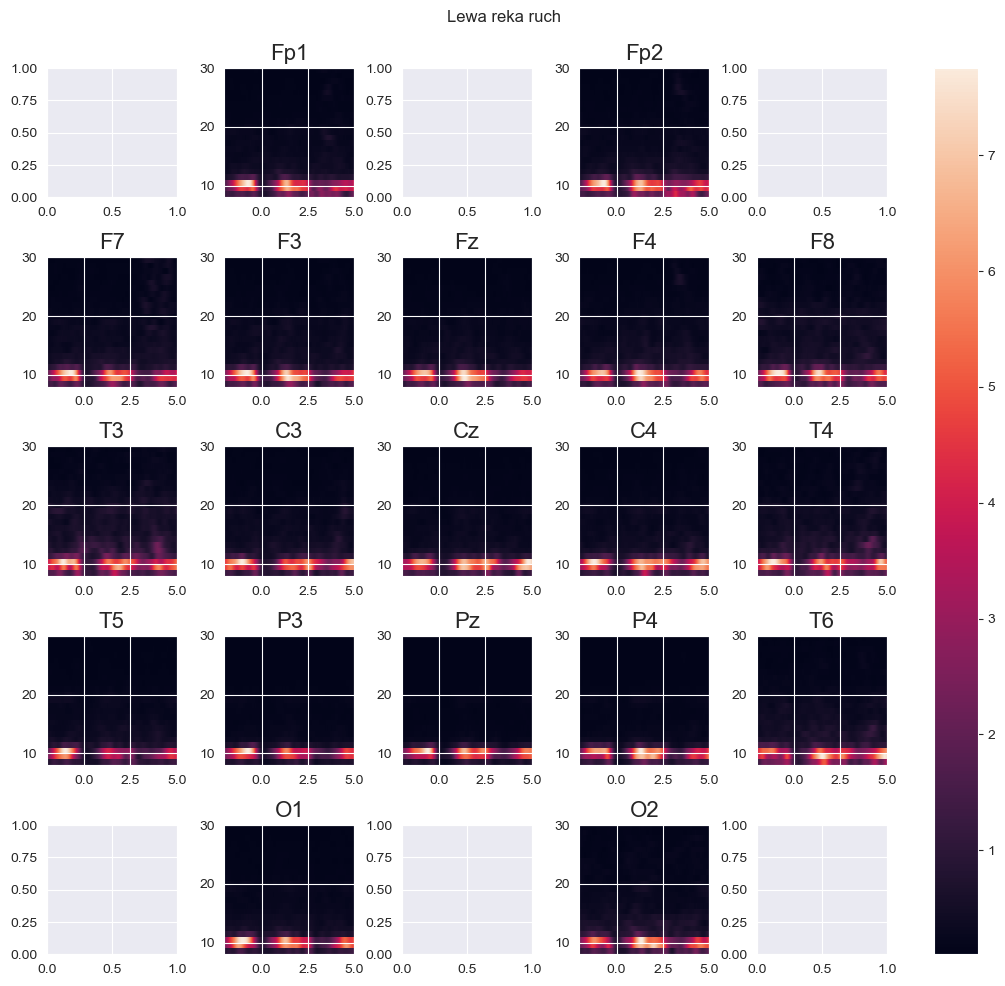

In [6]:
plot_head_spectrogram(EEG['Sxx_mean'][0], EEG['t'], EEG['f'], EEG['sampling'], NFFT, EEG['channels_names'], title="Lewa reka ruch")

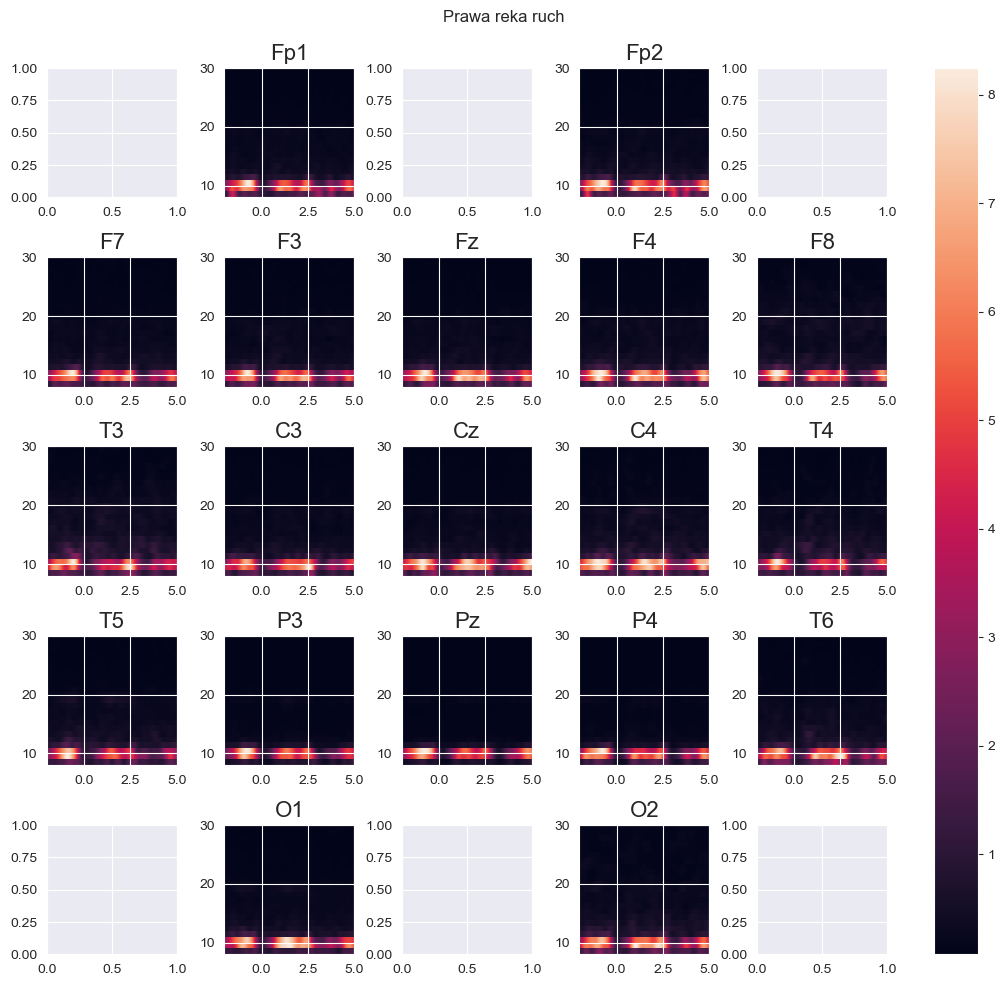

In [7]:
plot_head_spectrogram(EEG['Sxx_mean'][1], EEG['t'], EEG['f'], EEG['sampling'], NFFT, EEG['channels_names'], title="Prawa reka ruch")

W spektrogramach można zaobserwować spadek mocy w paśmie alfa (8-13 Hz) w odpowiedzi na rozpoczęcie ruchu - czyli event-related desychronization (ERD). Szególnie widoczne nad korą motoryczną (u nas Pz, P4 dla lewej ręki i P3, Pz dla prawej ręki).

## Spektrogramy po normalizacji 1

In [8]:
BASELINE = 2
Sxx = EEG['Sxx'].copy()
baseline = Sxx[:,:,:,:,0:int(BASELINE*Fs)].mean(axis=(4,1))
Sxx_mean = Sxx.mean(axis=1)
Sxx_normalized = (Sxx_mean - baseline[..., np.newaxis])/baseline[..., np.newaxis]
EEG['Sxx_norm_1'] = Sxx_normalized

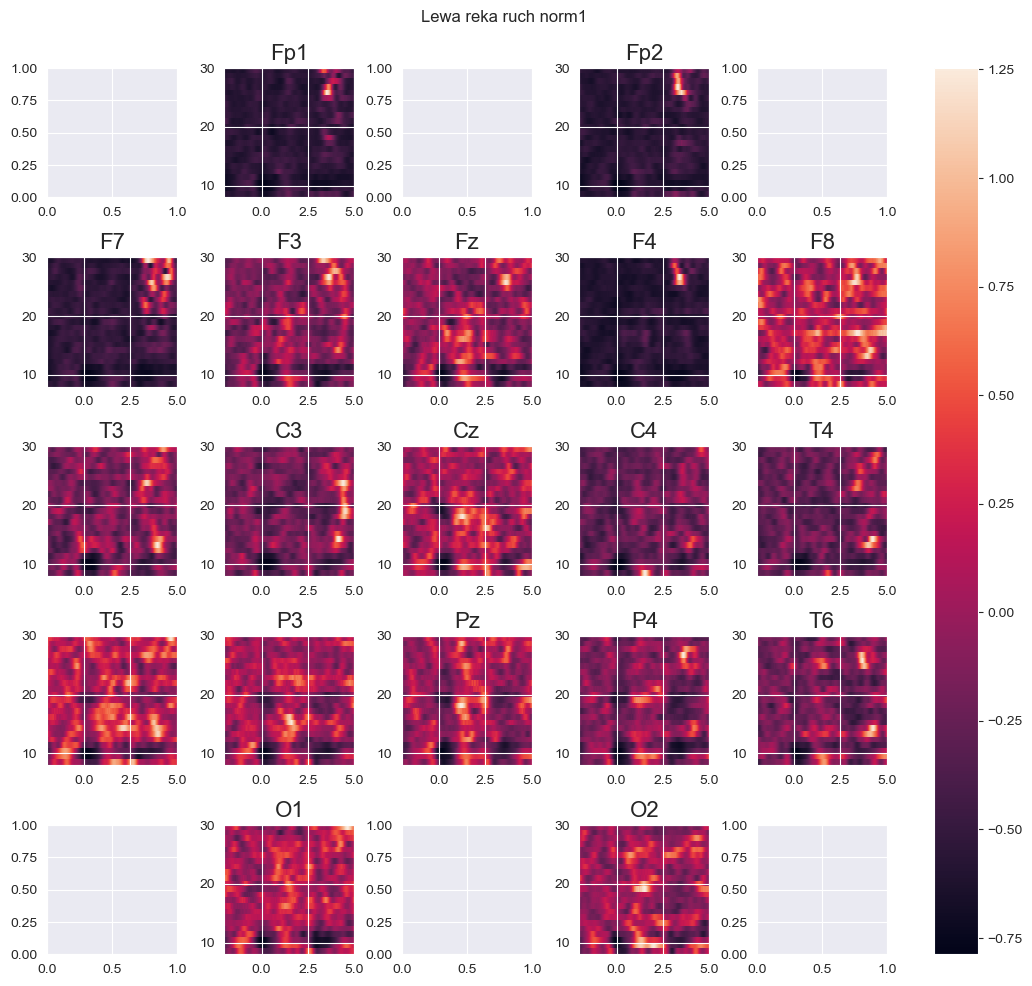

In [9]:
plot_head_spectrogram(EEG['Sxx_norm_1'][0], EEG['t'], EEG['f'], EEG['sampling'], NFFT, EEG['channels_names'], title="Lewa reka ruch norm1")

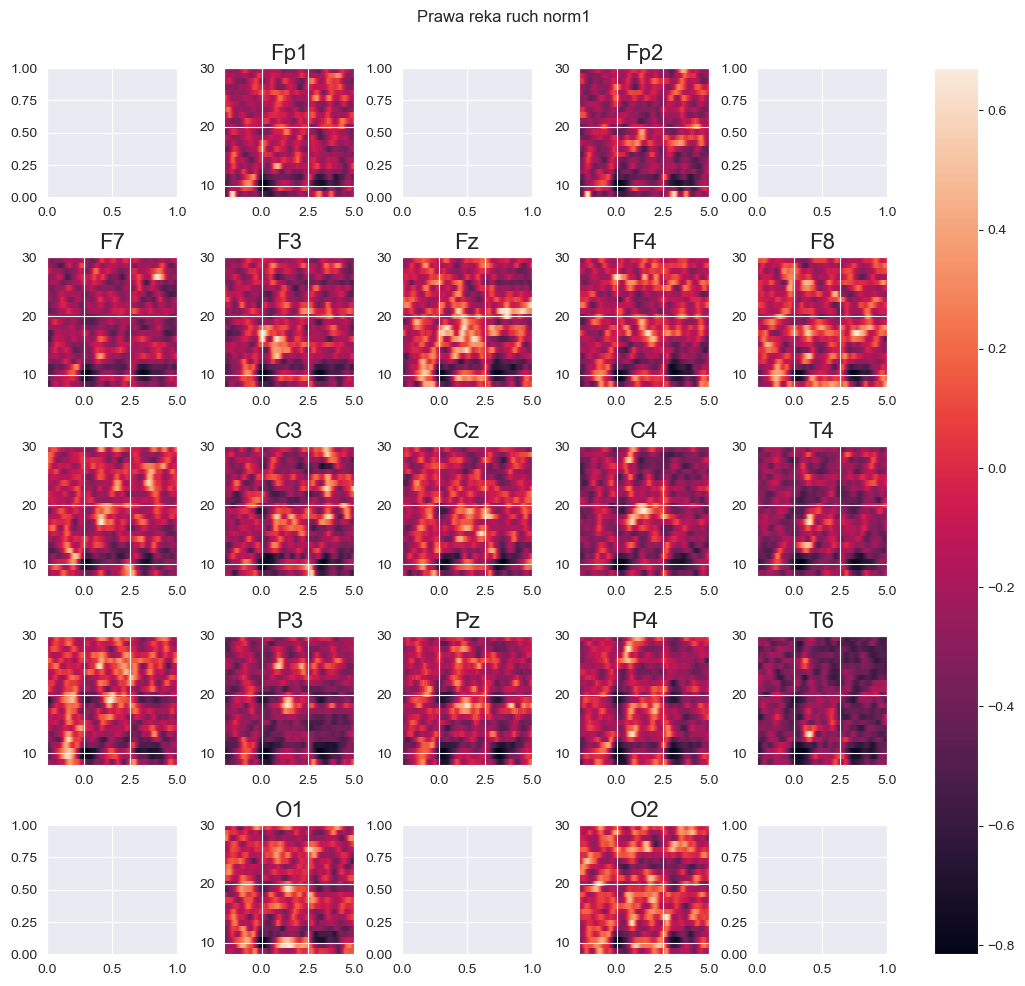

In [10]:
plot_head_spectrogram(EEG['Sxx_norm_1'][1], EEG['t'], EEG['f'], EEG['sampling'], NFFT, EEG['channels_names'], title="Prawa reka ruch norm1")

## Spektrogramy po normalizacji 2

In [11]:
BASELINE = 2
Sxx = EEG['Sxx'].copy()
baseline_mean = Sxx[:,:,:,:,0:int(BASELINE*Fs)].mean(axis=(1,4))
baseline_std = Sxx[:,:,:,:,0:int(BASELINE*Fs)].std(axis=(1,4))
Sxx_mean = Sxx.mean(axis=1)
Sxx_normalized = (Sxx_mean - baseline_mean[..., np.newaxis])/baseline_std[..., np.newaxis]
EEG['Sxx_norm_2'] = Sxx_normalized

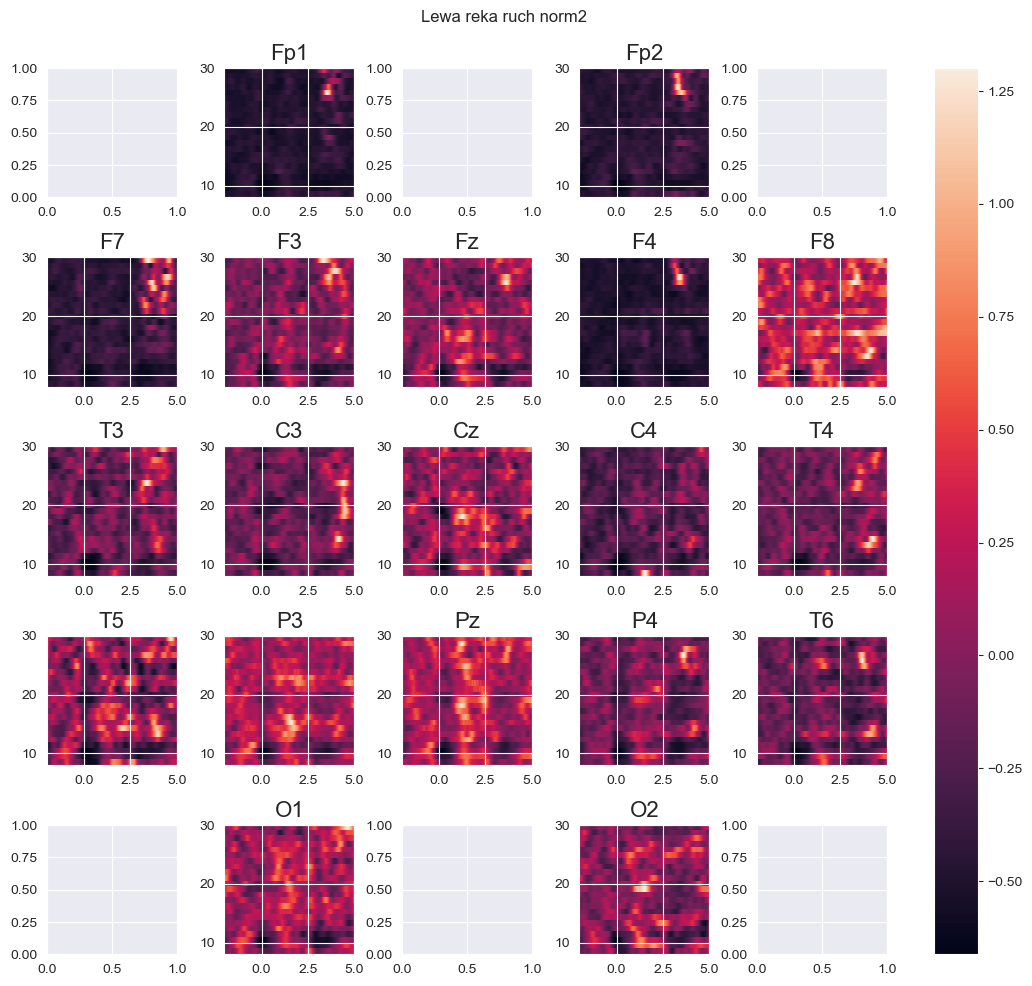

In [12]:
plot_head_spectrogram(EEG['Sxx_norm_2'][0], EEG['t'], EEG['f'], EEG['sampling'], NFFT, EEG['channels_names'], title="Lewa reka ruch norm2")

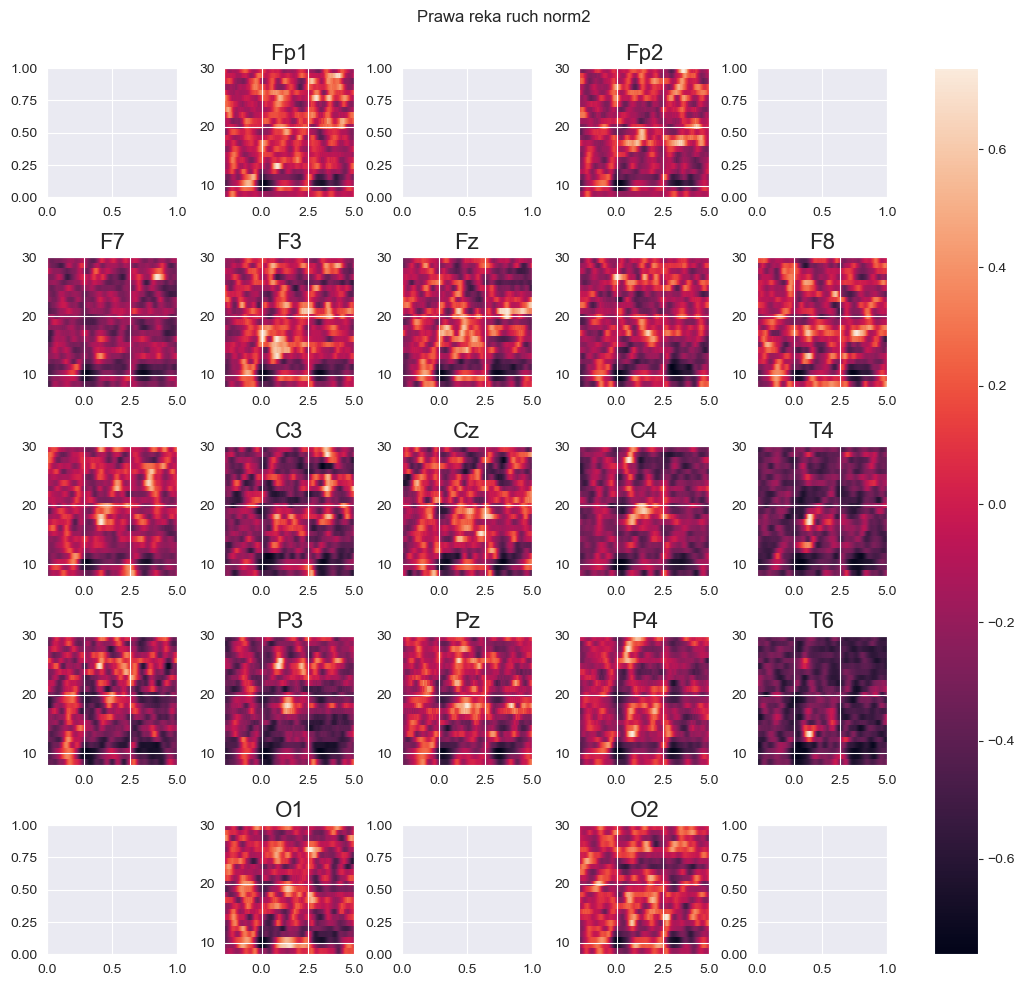

In [13]:
plot_head_spectrogram(EEG['Sxx_norm_2'][1], EEG['t'], EEG['f'], EEG['sampling'], NFFT, EEG['channels_names'], title="Prawa reka ruch norm2")

# Common Spatial Patterns

In [14]:
t = EEG['t']
X = EEG['merged']
n_ch = len(EEG['channels_names'])
n_rep = 30

In [15]:
from scipy import linalg
def csp(L, R):
    R_L = np.zeros((n_ch, n_ch))
    R_R = np.zeros((n_ch, n_ch))
    for r in range(n_rep):
        L_temp = L[r].T
        tmp = np.cov(L_temp, rowvar=False)
        regularizer = 1e-5 * np.eye(tmp.shape[0])
        tmp += regularizer
        R_L += tmp / np.trace(tmp)

        R_temp = R[r].T
        tmp = np.cov(R_temp, rowvar=False)
        regularizer = 1e-5 * np.eye(tmp.shape[0])
        tmp += regularizer
        R_R += tmp / np.trace(tmp)
    
    R_L /= n_rep
    R_R /= n_rep

    # Rozwiązanie uogólnionego zagadnienia własnego
    Lambda, W = linalg.eigh(R_L, R_R)

    return W


W = csp(X[0], X[1])

# Odzyskiwanie sygnałów źródłowych
S = np.zeros_like(X)
print(S.shape)

for r in range(n_rep):
    S[0, r, :, :] = W.T @ X[0, r, :, :]
    S[1, r, :, :] = W.T @ X[1, r, :, :]

EEG['CSP'] = S

(2, 30, 21, 2048)


## Spektrogram komponentów CSP

In [16]:
Fs = EEG['sampling']
NFFT = int(Fs)

h = np.hamming(NFFT)
EEG['sxx_f'], EEG['sxx_t'], EEG['sxx_CSP'] = spectrogram(EEG['CSP'], Fs, window=h, nperseg=NFFT, noverlap=NFFT-1, mode='psd', axis=-1)

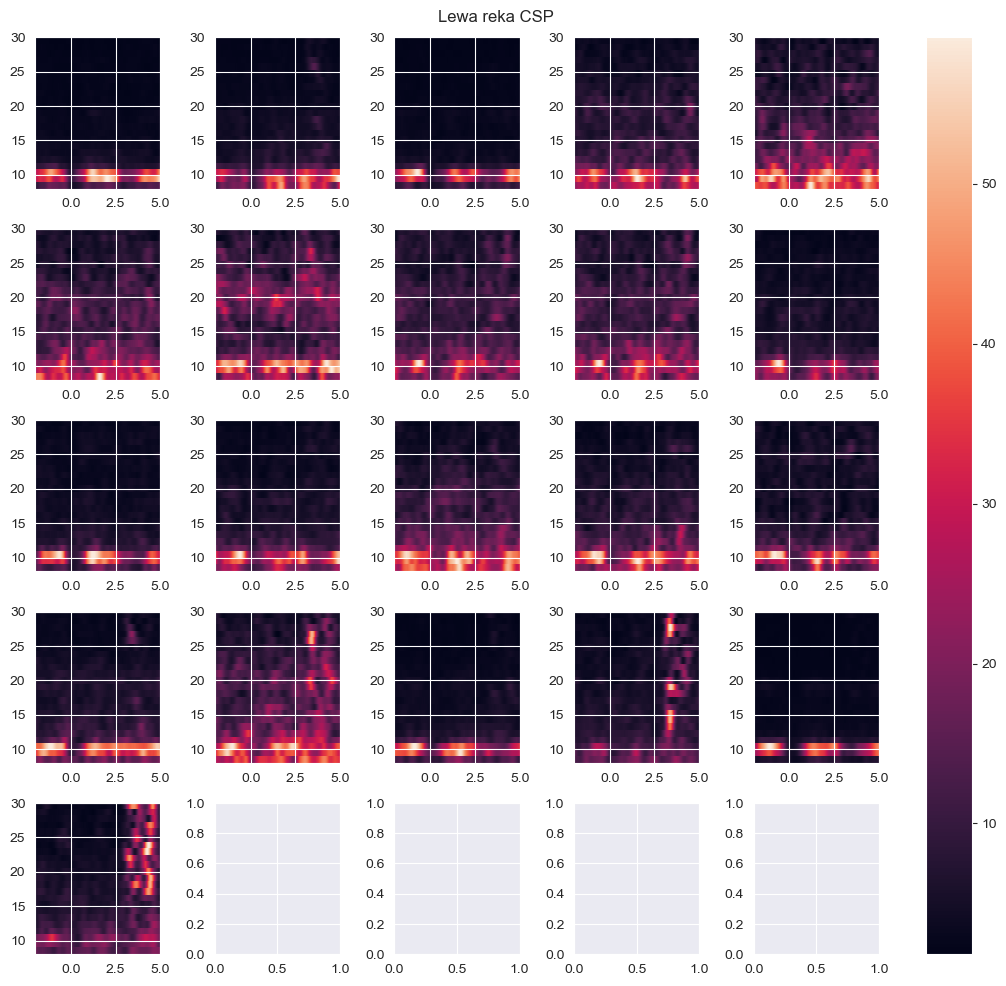

In [17]:
plot_components_spectrogram(EEG['sxx_CSP'][0].copy().mean(axis=0), EEG['sxx_t'], EEG['sxx_f'], title="Lewa reka CSP")

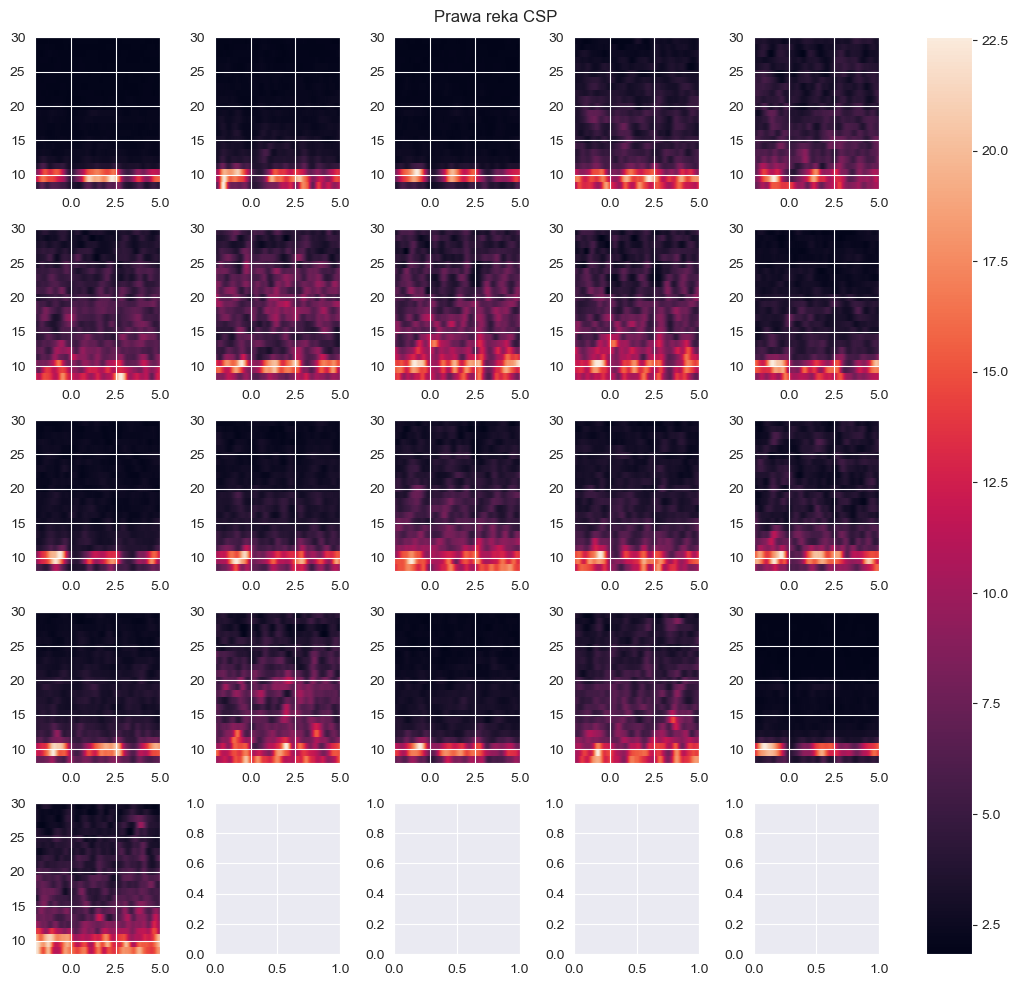

In [18]:
plot_components_spectrogram(EEG['sxx_CSP'][1].copy().mean(axis=0), EEG['sxx_t'], EEG['sxx_f'], title="Prawa reka CSP")

## Widma komponentów CSP

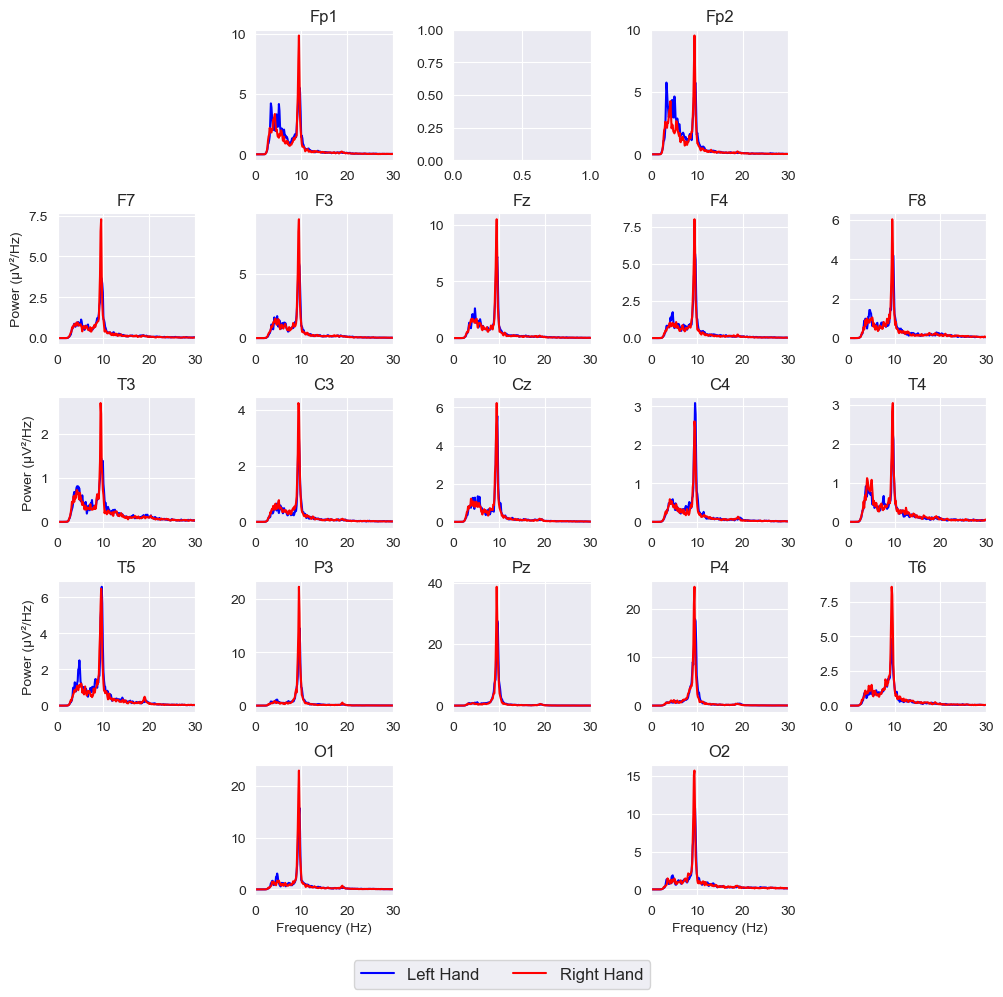

In [19]:
EEG['psd'], EEG['f'] = psd(EEG['merged'], Fs)
plot_head_psd(EEG['psd'][0].copy().mean(axis=0), EEG['psd'][1].copy().mean(axis=0), EEG['f'], EEG['channels_names'])
plt.show()

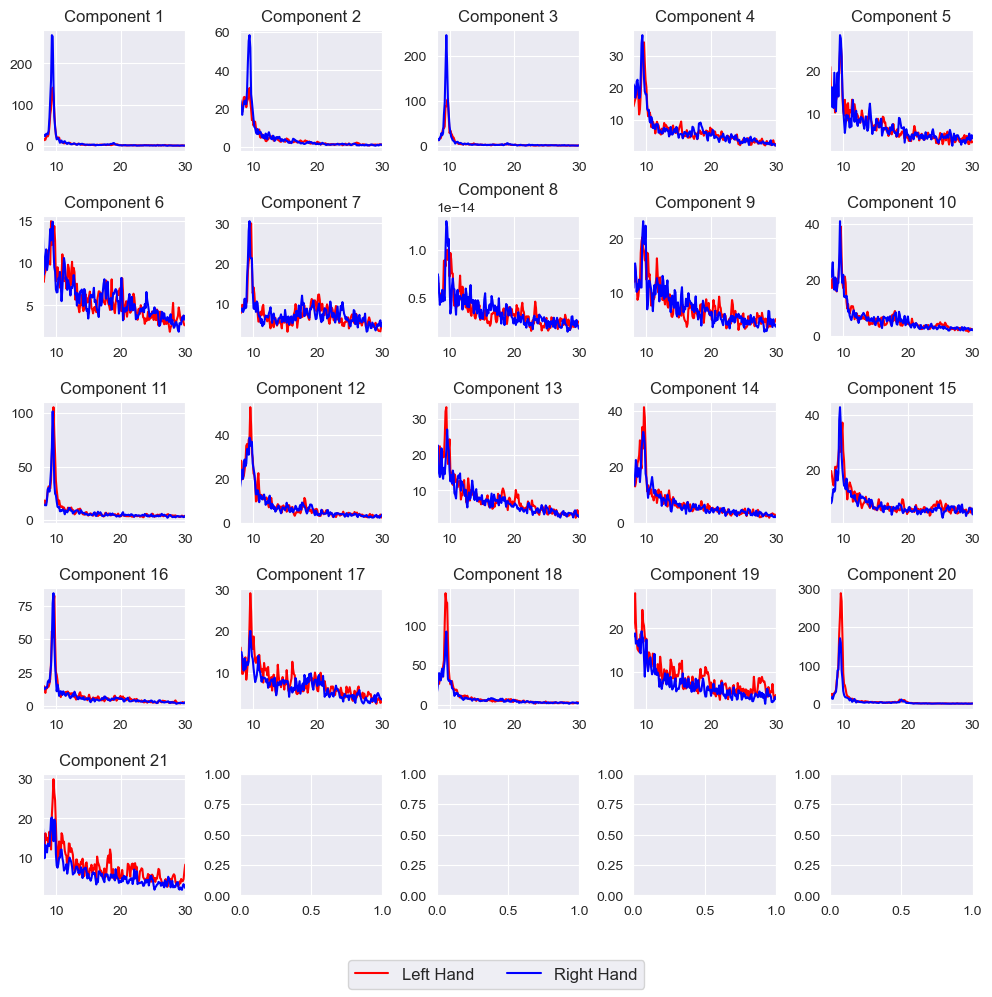

In [20]:
EEG['psd_CSP'], EEG['f'] = psd(EEG['CSP'], Fs)
plot_components_psd(EEG['psd_CSP'][0].copy().mean(axis=0), EEG['psd_CSP'][1].copy().mean(axis=0), EEG['f'], f_max=30)
plt.show()

# Wybór komponentów

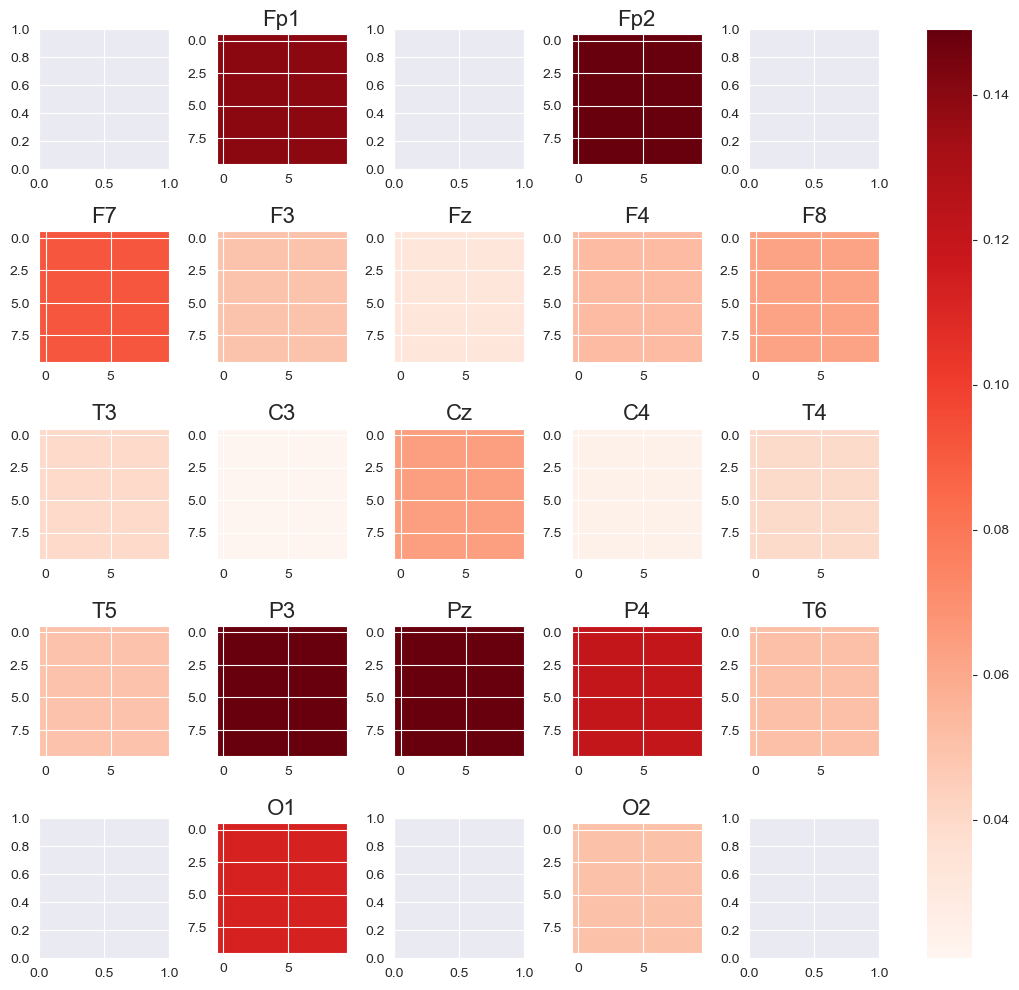

In [21]:
plot_head_csp(W, 2, EEG['channels_names'])

In [22]:
selected_components = [0, 1, 2, 17, 19]

# Stworzenie cech wejściowych do modelu

In [23]:
f = EEG['sxx_f']
f_min, f_max = 8, 30
freq_idxs = np.where((f >= f_min) & (f <= f_max))[0]

t = EEG['sxx_t'] - (NFFT / 2) / Fs - BASELINE
t_min, t_max = 0, 5
t_mask = (t >= t_min) & (t <= t_max)
time_idxs = np.where((t >= t_min) & (t <= t_max))[0]

component_mask = np.zeros(len(EEG['channels_names']), dtype=bool)
component_mask[np.array(selected_components)] = True

X = EEG['sxx_CSP'][:, :, component_mask, :, :]
X = X[:, :, :, freq_idxs, :]
X = X[:, :, :, :, time_idxs]
X = np.concatenate(X, axis=0)
X = X.reshape((X.shape[0], -1))

y = np.hstack((np.zeros(EEG['sxx_CSP'].shape[1]), np.ones(EEG['sxx_CSP'].shape[1])))

# Trenowanie i ewaluacja modelu 

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


def train_and_evaluate_classifier(X, y, classifier='lda', test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=True, random_state=random_state)

    if classifier == 'lda':
        model = LinearDiscriminantAnalysis()
    elif classifier == 'svm':
        model = SVC(kernel='linear', C=1, probability=True)
    else:
        raise ValueError("Classifier must be 'lda' or 'svm'")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)

    print(f"Classification accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Left Hand', 'Right Hand'],
                yticklabels=['Left Hand', 'Right Hand'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{classifier.upper()} Classification Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return model, accuracy

def cross_validate_model(X, y, classifier='lda', cv=5):
    if classifier == 'lda':
        model = LinearDiscriminantAnalysis()
    elif classifier == 'svm':
        model = SVC(kernel='linear', C=1)
    else:
        raise ValueError("Classifier must be 'lda' or 'svm'")

    cv_scores = cross_val_score(model, X, y, cv=cv)

    print(f"{cv}-fold cross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    return cv_scores


===== LDA Classifier =====
Classification accuracy: 0.5556

Confusion Matrix:
[[5 3]
 [5 5]]


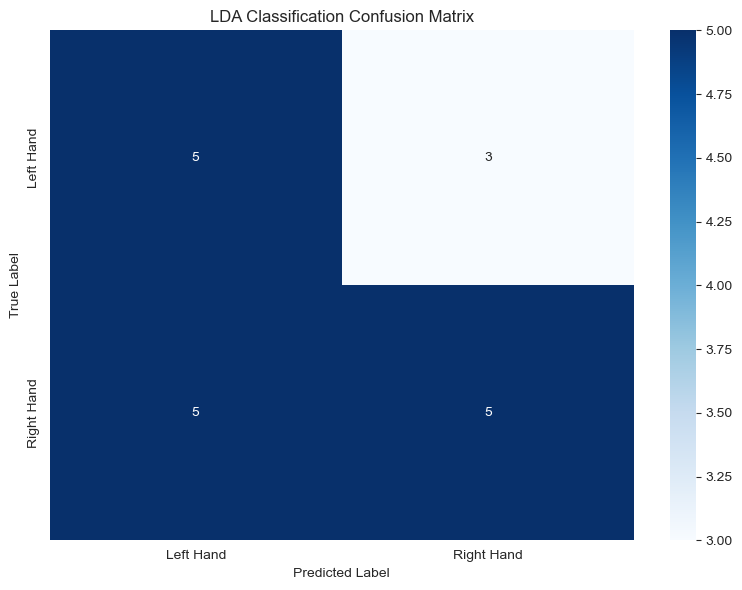


===== SVM Classifier =====
Classification accuracy: 0.3333

Confusion Matrix:
[[1 7]
 [5 5]]


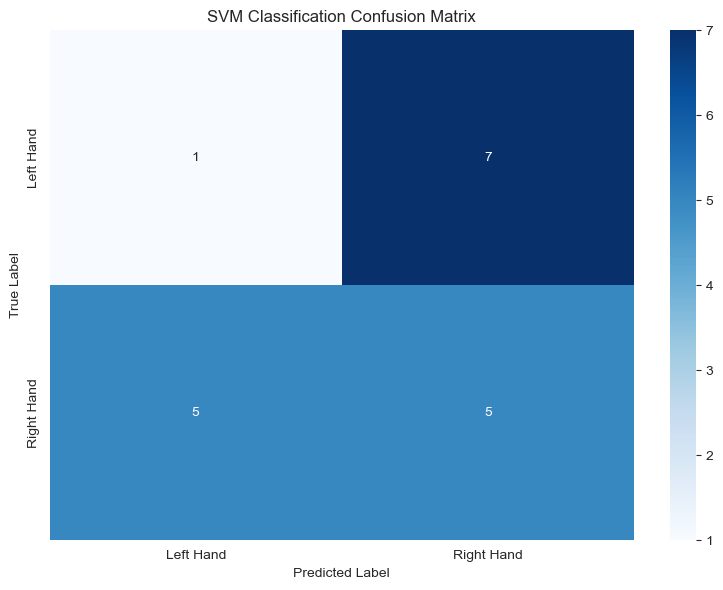


===== Cross-Validation =====
5-fold cross-validation scores: [0.5        0.66666667 0.41666667 0.41666667 0.83333333]
Mean CV accuracy: 0.5667 ± 0.1616
5-fold cross-validation scores: [0.33333333 0.66666667 0.25       0.58333333 0.58333333]
Mean CV accuracy: 0.4833 ± 0.1616


In [25]:
print("\n===== LDA Classifier =====")
lda_model, lda_accuracy = train_and_evaluate_classifier(X, y, classifier='lda')

print("\n===== SVM Classifier =====")
svm_model, svm_accuracy = train_and_evaluate_classifier(X, y, classifier='svm')

print("\n===== Cross-Validation =====")
lda_cv_scores = cross_validate_model(X, y, classifier='lda', cv=5)
svm_cv_scores = cross_validate_model(X, y, classifier='svm', cv=5)